**All the imports Needed**

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
import os
from PIL import Image
import matplotlib.pyplot as plt
from io import StringIO
from io import BytesIO
# import cStringIO
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch, cm
from reportlab.lib.utils import ImageReader
import matplotlib.pyplot as plt
import seaborn as sns
# import cStringIO
from reportlab.platypus import Image

from reportlab.platypus import Flowable

from pdfrw import PdfReader, PdfDict
from pdfrw.buildxobj import pagexobj
from pdfrw.toreportlab import makerl

**Reading Data**

In [2]:
data_csv = pd.read_csv("alldata.csv")
print(data_csv.head())

   Unnamed: 0             Quiz Name  Class  ZipGrade ID  level  School id  \
0           0  Level 1 5020 Aanchal    NaN      5020005      1     5020.0   
1           1  Level 1 5020 Aanchal    NaN      5020074      1     5020.0   
2           2  Level 1 5020 Aanchal    NaN      5020072      1     5020.0   
3           3  Level 1 5020 Aanchal    NaN      5020041      1     5020.0   
4           4  Level 1 5020 Aanchal    NaN      5020019      1     5020.0   

   First Name  Last Name  Num Questions  Num Correct ...   Q36  Q37  Q38  Q39  \
0         NaN        NaN            180           44 ...     0    0    0    0   
1         NaN        NaN            180           36 ...     0    0    0    0   
2         NaN        NaN            180           52 ...     0    4    0    0   
3         NaN        NaN            180           68 ...     0    4    0    0   
4         NaN        NaN            180           72 ...     4    4    0    4   

   Q40  Q41  Q42  Q43  Q44  Q45  
0    0    0    0

**Data transposing, skill labelling and difficulty labelling of questions**

In [3]:
numSkills=5
questionStartIndex=1
questionEndIndex=45
numQuestions=(questionEndIndex-questionStartIndex+1)
numberOfDifficultyLevels=5.0
if((questionEndIndex-questionStartIndex+1)%numberOfDifficultyLevels!=0):
    print('There is uneven divide in the difficulty levels. Please look into it.')
else:
    print('Each difficulty level has same number of questions.This is nice!')
questionsInEachDifficultyLevel=(questionEndIndex-questionStartIndex+1)/numberOfDifficultyLevels
q_cols = ['Q' + str(i) for i in range(questionStartIndex,questionEndIndex+1)]
answerCols=data_csv[q_cols]
numStudents=answerCols.shape[0]
# correctResponsesForEachQuestion=answerCols.astype(bool).sum(axis=0)
# sortedcorrectResponsesForEachQuestion=correctResponsesForEachQuestion.sort_values(ascending=True)
# sortedcorrectResponsesForEachQuestionDf=sortedcorrectResponsesForEachQuestion.to_frame()
transposed_df=answerCols.transpose()
transposed_df['numCorrect']=transposed_df.astype(bool).sum(axis=1)
transposed_df['qid'] = range(questionStartIndex, questionStartIndex+len(transposed_df))
transposed_df['correctPercentage']=transposed_df['numCorrect']*100.0/numStudents
transposed_df['skillType']=0
transposed_df.loc[(transposed_df['qid']>=1)&(transposed_df['qid']<=10),'skillType' ]=1
transposed_df.loc[(transposed_df['qid']>=11)&(transposed_df['qid']<=20),'skillType' ]=2
transposed_df.loc[(transposed_df['qid']>=21)&(transposed_df['qid']<=30),'skillType' ]=3
transposed_df.loc[(transposed_df['qid']>=31)&(transposed_df['qid']<=40),'skillType' ]=4
transposed_df.loc[(transposed_df['qid']>=41)&(transposed_df['qid']<=45),'skillType' ]=5
colsReqd=['numCorrect','qid','correctPercentage','skillType']
reqdDf=transposed_df[colsReqd].sort_values('correctPercentage',ascending=False)
reqdDf['difficulty_level']=0
for i in range(1,int(numberOfDifficultyLevels+1)):
    reqdDf.iloc[int((i-1)*questionsInEachDifficultyLevel):int((i)*questionsInEachDifficultyLevel),-1]=i

Each difficulty level has same number of questions.This is nice!


**Histogram of Question number to percentage of people who answered it correctly**

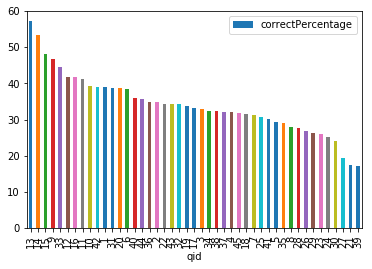

In [4]:
reqdDf.plot(kind='bar',x='qid',y='correctPercentage')

**Table of Question Wise Details ie. percentageCorrectlyAnswered, skill-type and difficulty-level**

In [5]:
print(reqdDf.sort_values('qid'))

     numCorrect  qid  correctPercentage  skillType  difficulty_level
Q1          880    1          38.989809          1                 2
Q2          788    2          34.913602          1                 2
Q3          742    3          32.875498          1                 3
Q4          723    4          32.033673          1                 4
Q5          659    5          29.198051          1                 4
Q6          869    6          38.502437          1                 2
Q7          708    7          31.369074          1                 4
Q8          632    8          28.001772          1                 4
Q9         1055    9          46.743465          1                 1
Q10         889   10          39.388569          1                 1
Q11         932   11          41.293753          2                 1
Q12         943   12          41.781125          2                 1
Q13        1292   13          57.244129          2                 1
Q14        1204   14          53.3

**Skill-Wise Difficulty Information**

           difficulty_level  skillType
skillType                             
1                       2.7          1
2                       1.8          2
3                       4.7          3
4                       2.8          4
5                       3.0          5


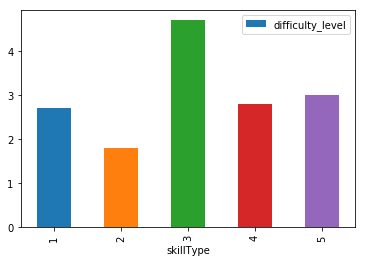

In [6]:
skillDifficultyDf=(reqdDf.groupby(['skillType'])['difficulty_level'].mean()).to_frame()
skillDifficultyDf['skillType']=skillDifficultyDf.index
print(skillDifficultyDf)
skillDifficultyDf.plot(kind='bar',x='skillType',y='difficulty_level')

**End of Task1**

**Start of Task2**

**Assigning Weight to each question as (1-fractionOfPeopleWhoAnsweredCorrectly)**

In [7]:
reqdDf['weight']=1-(reqdDf['correctPercentage']/100)
print(reqdDf.head())

     numCorrect  qid  correctPercentage  skillType  difficulty_level    weight
Q13        1292   13          57.244129          2                 1  0.427559
Q14        1204   14          53.345148          2                 1  0.466549
Q15        1084   15          48.028356          2                 1  0.519716
Q9         1055    9          46.743465          1                 1  0.532565
Q33        1006   33          44.572441          4                 1  0.554276


**Calculating data for each student**

In [9]:
studentIdArray=data_csv['ZipGrade ID'].values
responsesArray=answerCols.values
dict_correctResponses={}
dict_wrongResponses={}
dict_skill_correct={}
dict_skill_incorrect={}
for c_skillType in range(1,numSkills+1):
    dict_skill_correct[c_skillType]={}
    dict_skill_incorrect[c_skillType]={}
skillWiseScore={}
for t in range(numStudents):
    currStudentId=studentIdArray[t]
    currResponses=responsesArray[t]
    currDf=reqdDf.copy()
    currDf['response']=currResponses
    currDf['qStr']=currDf.index
    correctMask=(currDf['response'].astype(bool)==True)
    incorrectMask=(currDf['response'].astype(bool)==False)
    for c_skillType in range(1,numSkills+1):
        c_skillMask=(currDf['skillType']==c_skillType)
        cs_correctMask = correctMask & c_skillMask
        cs_incorrectMask = incorrectMask & c_skillMask
        dict_skill_correct[c_skillType][currStudentId] =  cs_correctMask.sum()
        dict_skill_incorrect[c_skillType][currStudentId] =  cs_incorrectMask.sum()
    correctlyAnsweredQuestions=currDf['qStr'][correctMask].values
    wronglyAnsweredQuestions=currDf['qStr'][incorrectMask].values
    dict_correctResponses[currStudentId]=correctlyAnsweredQuestions
    dict_wrongResponses[currStudentId]=wronglyAnsweredQuestions
    curr_skill_weight_df=(currDf[correctMask].groupby(['skillType'])['weight'].sum().to_frame())
    for c_skillType in range(1,numSkills+1):
        if(c_skillType not in curr_skill_weight_df.index):
            curr_skill_weight_df.loc[c_skillType] = [0.0]
    skillWiseScore[currStudentId]=(curr_skill_weight_df.reset_index().sort_values('skillType'))['weight'].values

**Relevant data for a student being fetched with student_id**

In [10]:
studentId_whoseInfoIsNeeded=5012012
print('Correctly Answered Questions:',dict_correctResponses[studentId_whoseInfoIsNeeded])
print('Wrongly Answered Questions:',dict_wrongResponses[studentId_whoseInfoIsNeeded])
print('Skill Wise Weighted Scores:',skillWiseScore[studentId_whoseInfoIsNeeded])
print('Total Score:',skillWiseScore[studentId_whoseInfoIsNeeded].sum())

Correctly Answered Questions: ['Q14' 'Q15' 'Q40' 'Q22' 'Q43' 'Q32' 'Q17' 'Q4' 'Q18' 'Q29' 'Q21']
Wrongly Answered Questions: ['Q13' 'Q9' 'Q33' 'Q12' 'Q16' 'Q11' 'Q10' 'Q42' 'Q1' 'Q31' 'Q20' 'Q6'
 'Q44' 'Q36' 'Q2' 'Q19' 'Q3' 'Q34' 'Q38' 'Q37' 'Q45' 'Q7' 'Q25' 'Q41' 'Q5'
 'Q35' 'Q8' 'Q28' 'Q26' 'Q23' 'Q24' 'Q30' 'Q27' 'Q39']
Skill Wise Weighted Scores: [0.67966327 2.33805937 2.21754541 1.29951263 0.65618077]
Total Score: 7.190961453256536


**Adding Ranking data for each student for each skill**

In [11]:
studentScoresDf=pd.DataFrame.from_dict(skillWiseScore).transpose()
studentScoresDf.columns = ['score_skill_' + str(i) for i in range(1,numSkills+1)]
studentScoresDf['score_skill_0'] = studentScoresDf.sum(axis=1)
for i in range(numSkills+1):
    studentScoresDf['skill_rank_'+str(i)] = studentScoresDf['score_skill_'+str(i)].rank(ascending=False,method='first')
print(studentScoresDf)

         score_skill_1  score_skill_2  score_skill_3  score_skill_4  \
5020005       1.753655       2.093487       0.000000       1.904298   
5020074       1.301285       1.661054       0.693398       1.928666   
5020072       1.827204       2.141781       0.722641       1.287107   
5020041       2.433319       3.921134       1.482056       1.262738   
5020019       1.867523       3.476296       2.265840       2.080638   
5020061       1.221090       2.959681       2.182986       1.920691   
5020004       1.147541       1.476739       2.250332       2.126717   
5020040       1.827204       1.626938       0.722641       1.941958   
5020010       2.498449       2.801063       1.463447       1.939743   
5020017       1.225078       3.396101       2.265840       1.967656   
502003        0.614976       1.078866       0.000000       1.292424   
5020052       2.439965       1.622065       1.548073       3.137794   
5020050       0.614976       1.622508       0.731502       0.641560   
502002

**Making String for each part which is to be flushed to the pdf**

In [17]:
c_studentId=5012026
lbreak_reportlab='<br/>'
correctAnswerStr='CORRECTLY ANSWERED QUESTIONS'+lbreak_reportlab+lbreak_reportlab+lbreak_reportlab
for q_index in dict_correctResponses[c_studentId]:
    curr_correctPercentage=(reqdDf.loc[q_index,'correctPercentage'])
    curr_weight=(reqdDf.loc[q_index,'weight'])
    correctAnswerStr+='QuestionNumber::'+q_index+lbreak_reportlab
    correctAnswerStr+='CorrectPercentage::'+str(curr_correctPercentage)+lbreak_reportlab
    correctAnswerStr+='ProblemWeight::'+str(curr_weight)+lbreak_reportlab
    correctAnswerStr+=(lbreak_reportlab)

wrongAnswerStr='INCORRECTLY ANSWERED QUESTIONS'+lbreak_reportlab+lbreak_reportlab
for q_index in dict_wrongResponses[c_studentId]:
    curr_correctPercentage=(reqdDf.loc[q_index,'correctPercentage'])
    curr_weight=(reqdDf.loc[q_index,'weight'])
    wrongAnswerStr+='QuestionNumber::'+q_index+lbreak_reportlab
    wrongAnswerStr+='CorrectPercentage::'+str(curr_correctPercentage)+lbreak_reportlab
    wrongAnswerStr+='ProblemWeight::'+str(curr_weight)+lbreak_reportlab
    wrongAnswerStr+=(lbreak_reportlab)  

In [18]:
overallResult="AGGREGATED SUMMARY"+lbreak_reportlab
overallResult+="Student Rank:"+str(studentScoresDf.loc[c_studentId,'skill_rank_0'])+" out of "+ str(numStudents)+lbreak_reportlab+' Total Score :'+str(studentScoresDf.loc[c_studentId,'score_skill_0'])+lbreak_reportlab

In [19]:
scoreRankStr="SKILL WISE RESULTS"+lbreak_reportlab+lbreak_reportlab+lbreak_reportlab+lbreak_reportlab
for t in range(1,numSkills+1):
    scoreRankStr+= "RESULTS FOR SKILL "+ str(t)+lbreak_reportlab+lbreak_reportlab
    scoreRankStr+="Skill_Rank:"+str(studentScoresDf.loc[c_studentId,'skill_rank_'+str(t)])+" out of "+ str(numStudents)+lbreak_reportlab
    scoreRankStr+='Skill_Score:'+str(studentScoresDf.loc[c_studentId,'score_skill_'+str(t)])+lbreak_reportlab
    scoreRankStr+='Correctly Answered:'+str(dict_skill_correct[t][c_studentId])+lbreak_reportlab
    scoreRankStr+='InCorrectly Answered:'+str(dict_skill_incorrect[t][c_studentId])+lbreak_reportlab
    scoreRankStr+=lbreak_reportlab+lbreak_reportlab+lbreak_reportlab

**Final Flushing data to the Pdf**

In [20]:
# Sample platypus document
# From the FAQ at reportlab.org/oss/rl-toolkit/faq/#1.1
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.rl_config import defaultPageSize
from reportlab.lib.units import inch

PAGE_HEIGHT=defaultPageSize[1]
PAGE_WIDTH=defaultPageSize[0]
styles = getSampleStyleSheet()
Title = "Student Report__"+str(c_studentId)
pageinfo = c_studentId

def myFirstPage(canvas, doc):
    canvas.saveState()
    canvas.setFont('Times-Bold',16)
    canvas.drawCentredString(PAGE_WIDTH/2.0, PAGE_HEIGHT-108, Title)
    canvas.setFont('Times-Roman',9)
    canvas.drawString(inch, 0.75 * inch,"First Page / %s" % pageinfo)
    canvas.restoreState()
    
def myLaterPages(canvas, doc):
    canvas.saveState()
    canvas.setFont('Times-Roman', 9)
    canvas.drawString(inch, 0.75 * inch,"Page %d %s" % (doc.page, pageinfo))
    canvas.restoreState()
    
def go():
    doc = SimpleDocTemplate("phello.pdf")
    Story = [Spacer(1,2*inch)]
    style = styles["Normal"]
    p = Paragraph(correctAnswerStr, style)
    Story.append(p)
    Story.append(Spacer(1,0.2*inch))
    p = Paragraph(wrongAnswerStr, style)
    Story.append(p)
    Story.append(Spacer(1,0.2*inch))
    
    p = Paragraph(overallResult, style)
    Story.append(p)
    Story.append(Spacer(1,0.2*inch))
    
    p = Paragraph(scoreRankStr, style)
    Story.append(p)
    Story.append(Spacer(1,0.2*inch))
    doc.build(Story, onFirstPage=myFirstPage, onLaterPages=myLaterPages)
    
if __name__ == "__main__":
    go()

**Example of how what type of chart can be inserted for each question**

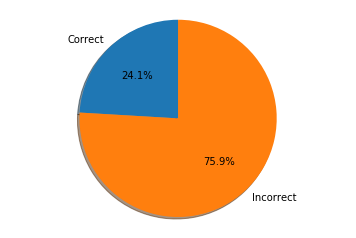

In [35]:
for q_index in dict_correctResponses[c_studentId]:
    curr_correctPercentage=(reqdDf.loc[q_index,'correctPercentage'])
    curr_weight=(reqdDf.loc[q_index,'weight'])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Correct', 'Incorrect'
sizes = [curr_correctPercentage, 100.0-curr_correctPercentage]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# sns_plot.figure.savefig(imgdata, format='png')

# imgdata = StringIO()
imgdata = BytesIO()
fig1.savefig(imgdata, format='png')
# plt.figure.savefig(imgdata, format='png')
imgdata.seek(0)  # rewind the data

Image = ImageReader(imgdata)

c = canvas.Canvas('test.pdf')
c.drawImage(Image, cm, cm, inch, inch)
c.save()

**Code to add Plots as well as Textual Data**

Plots Help is taken from answer on: https://stackoverflow.com/questions/31712386/loading-matplotlib-object-into-reportlab/32021013

**Below Cell is used helpful for adding Plots to Report by Helping them to be added to a Story**

In [53]:
def form_xo_reader(imgdata):
    page, = PdfReader(imgdata).pages
    return pagexobj(page)


class PdfImage(Flowable):
    def __init__(self, img_data, width=200, height=200):
        self.img_width = width
        self.img_height = height
        self.img_data = img_data

    def wrap(self, width, height):
        return self.img_width, self.img_height

    def drawOn(self, canv, x, y, _sW=0):
        if _sW > 0 and hasattr(self, 'hAlign'):
            a = self.hAlign
            if a in ('CENTER', 'CENTRE', TA_CENTER):
                x += 0.5*_sW
            elif a in ('RIGHT', TA_RIGHT):
                x += _sW
            elif a not in ('LEFT', TA_LEFT):
                raise ValueError("Bad hAlign value " + str(a))
        canv.saveState()
        img = self.img_data
        if isinstance(img, PdfDict):
            xscale = self.img_width / img.BBox[2]
            yscale = self.img_height / img.BBox[3]
            canv.translate(x, y)
            canv.scale(xscale, yscale)
            canv.doForm(makerl(canv, img))
        else:
            canv.drawImage(img, x, y, self.img_width, self.img_height)
        canv.restoreState()
        


def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]


In [60]:
c_studentId=5109082
lbreak_reportlab='<br/>'


# Sample platypus document
# From the FAQ at reportlab.org/oss/rl-toolkit/faq/#1.1
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.rl_config import defaultPageSize
from reportlab.lib.units import inch

PAGE_HEIGHT=defaultPageSize[1]
PAGE_WIDTH=defaultPageSize[0]
styles = getSampleStyleSheet()
Title = "Student Report__"+str(c_studentId)
pageinfo = c_studentId

def myFirstPage(canvas, doc):
    canvas.saveState()
    canvas.setFont('Times-Bold',16)
    canvas.drawCentredString(PAGE_WIDTH/2.0, PAGE_HEIGHT-108, Title)
    canvas.setFont('Times-Roman',9)
    canvas.drawString(inch, 0.75 * inch,"First Page / %s" % pageinfo)
    canvas.restoreState()
    
def myLaterPages(canvas, doc):
    canvas.saveState()
    canvas.setFont('Times-Roman', 9)
    canvas.drawString(inch, 0.75 * inch,"Page %d %s" % (doc.page, pageinfo))
    canvas.restoreState()
    
def go():
    doc = SimpleDocTemplate("reportWithGraphs.pdf")
    Story = [Spacer(1,2*inch)]
    style = styles["Normal"]
    
    ##################################################################################################
    ##################################################################################################
    #############################OVERALL AND SKILL RANKINGS###########################################
    ##################################################################################################
    ##################################################################################################
    
    overallResult="AGGREGATED SUMMARY"+lbreak_reportlab
    overallResult+="Your overall rank is : "+str(studentScoresDf.loc[c_studentId,'skill_rank_0'])+" out of "+ str(numStudents)+lbreak_reportlab+' Total Score :'+str(studentScoresDf.loc[c_studentId,'score_skill_0'])+lbreak_reportlab
    
    p = Paragraph(overallResult, style)
    Story.append(p)
    Story.append(Spacer(1,0.2*inch))
    
    
    
    
    scoreRankStr="SKILL WISE RESULTS"+lbreak_reportlab+lbreak_reportlab+lbreak_reportlab+lbreak_reportlab
    for t in range(1,numSkills+1):
        scoreRankStr+= "RESULTS FOR SKILL "+ str(t)+lbreak_reportlab+lbreak_reportlab
        scoreRankStr+="Skill_Rank:"+str(studentScoresDf.loc[c_studentId,'skill_rank_'+str(t)])+" out of "+ str(numStudents)+lbreak_reportlab
        scoreRankStr+='Skill_Score:'+str(studentScoresDf.loc[c_studentId,'score_skill_'+str(t)])+lbreak_reportlab
        scoreRankStr+='Correctly Answered:'+str(dict_skill_correct[t][c_studentId])+lbreak_reportlab
        scoreRankStr+='InCorrectly Answered:'+str(dict_skill_incorrect[t][c_studentId])+lbreak_reportlab
        scoreRankStr+=lbreak_reportlab+lbreak_reportlab+lbreak_reportlab
        
    p = Paragraph(scoreRankStr, style)
    Story.append(p)
    Story.append(Spacer(1,0.2*inch))
    
    ##################################################################################################
    ##################################################################################################
    #############################CORRECTLY ANSWERED QUESTIONS#########################################
    ##################################################################################################
    ##################################################################################################
    
    correctAnswerStr='CORRECTLY ANSWERED QUESTIONS'+lbreak_reportlab+lbreak_reportlab+lbreak_reportlab
    p = Paragraph(correctAnswerStr, style)
    Story.append(p)
    Story.append(Spacer(1,0.2*inch))
    
    for q_index in sorted(dict_correctResponses[c_studentId]):
        curr_ans_str=""
        curr_correctPercentage=(reqdDf.loc[q_index,'correctPercentage'])
        curr_weight=(reqdDf.loc[q_index,'weight'])
        curr_ans_str+=''+q_index+'. You Answered this question correctly'+lbreak_reportlab
        #curr_ans_str+='CorrectPercentage::'+str(curr_correctPercentage)+lbreak_reportlab
        #curr_ans_str+='ProblemWeight::'+str(curr_weight)+lbreak_reportlab
        curr_ans_str+=(lbreak_reportlab)
        
        p = Paragraph(curr_ans_str, style)
        Story.append(p)
        Story.append(Spacer(1,0.2*inch))

        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = 'Correct', 'Incorrect'
        sizes = [curr_correctPercentage, 100.0-curr_correctPercentage]
        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        imgdata = BytesIO()
        fig1.savefig(imgdata, format='png')
        # plt.figure.savefig(imgdata, format='png')
        imgdata.seek(0)  # rewind the data
        pieImage = ImageReader(imgdata)
        imgMy = PdfImage(pieImage, width=200, height=120)
        plt.close() 
        Story.append(imgMy)

    ##################################################################################################
    ##################################################################################################
    #############################INCORRECTLY ANSWERED QUESTIONS#######################################
    ##################################################################################################
    ##################################################################################################
    
    correctAnswerStr='INCORRECTLY ANSWERED QUESTIONS'+lbreak_reportlab+lbreak_reportlab+lbreak_reportlab
    p = Paragraph(correctAnswerStr, style)
    Story.append(p)
    Story.append(Spacer(1,0.2*inch))
    
    for q_index in sorted(dict_wrongResponses[c_studentId]):
        curr_ans_str=""
        curr_correctPercentage=(reqdDf.loc[q_index,'correctPercentage'])
        curr_weight=(reqdDf.loc[q_index,'weight'])
        curr_ans_str+=''+q_index+'. You Answered this question wrongly'+lbreak_reportlab
        #curr_ans_str+='CorrectPercentage::'+str(curr_correctPercentage)+lbreak_reportlab
        #curr_ans_str+='ProblemWeight::'+str(curr_weight)+lbreak_reportlab
        curr_ans_str+=(lbreak_reportlab)
        
        p = Paragraph(curr_ans_str, style)
        Story.append(p)
        Story.append(Spacer(1,0.2*inch))

        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = 'Correct', 'Incorrect'
        sizes = [curr_correctPercentage, 100.0-curr_correctPercentage]
        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        imgdata = BytesIO()
        fig1.savefig(imgdata, format='png')
        # plt.figure.savefig(imgdata, format='png')
        imgdata.seek(0)  # rewind the data
        pieImage = ImageReader(imgdata)
        imgMy = PdfImage(pieImage, width=200, height=120)
        plt.close() 
        Story.append(imgMy)
        
        
        
    

    doc.build(Story, onFirstPage=myFirstPage, onLaterPages=myLaterPages)
    
if __name__ == "__main__":
    go()